# 🎓 **Taller 4.3: Taller de Métodos de clustering basados en particiones Parte 2**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [64]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


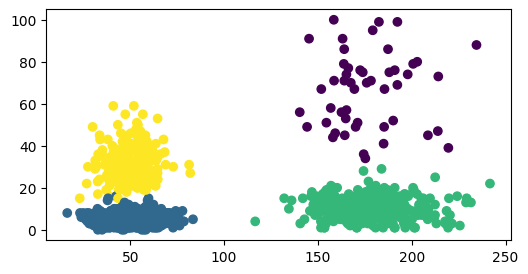

In [65]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [66]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[193.79850439  23.25910136]
 [208.5839598   95.15279722]
 [ 77.63868534  56.81286394]
 [101.69562862  14.49760473]]


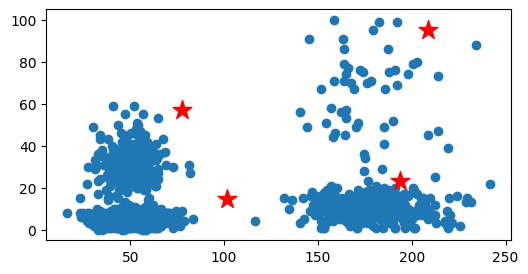

In [67]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [68]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

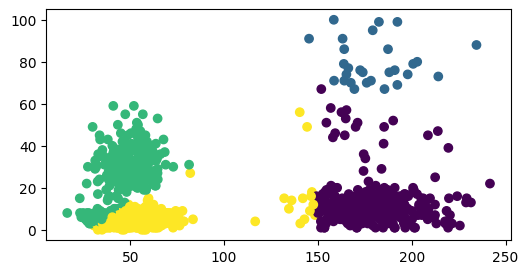

In [69]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [70]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

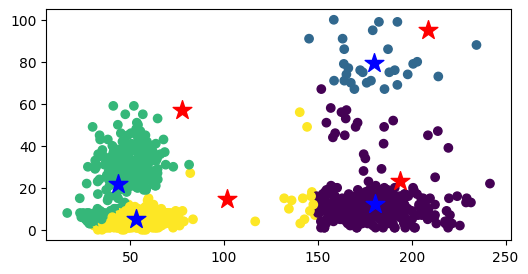

In [71]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [72]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

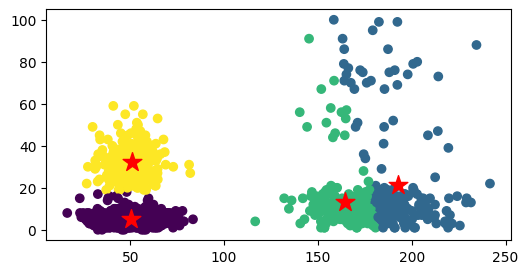

In [73]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 1: MODIFICA KMEANS PARA QUE SE CONVIERTA EN KMEANS++**

In [74]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima
          distances[i] = np.min(dist_to_centroids)# 1.1 Completa tu codigo aqui
      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx = np.random.choice(n_samples, p=probabilities)# 1.1 Completa tu codigo aqui
      cDx[k] = Dx[next_idx]
  return cDx

In [75]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros_inteligente(K, Dx)
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

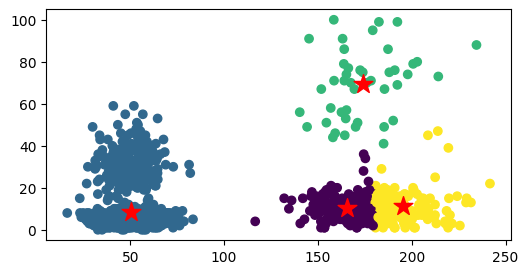

In [76]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: USA EL METODO DEL CODO CON KMEANS++ PARA DETERMINAR EL MEJOR K**
<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


In [77]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [78]:
def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

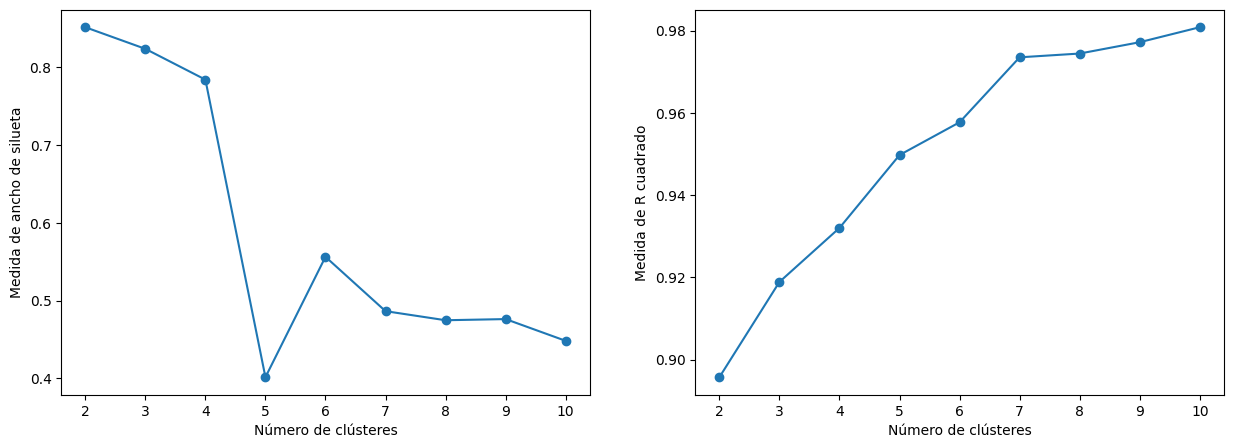

In [79]:
#METODO DEL CODO
# voy a probar para valores de k desde 2 al 11
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp)
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Redacte una conclusión que analice los gráficos del método del codo y del coeficiente de silueta (y/o R²) para la selección del número de clusters (k). Indique cuál es el valor óptimo de k y fundamente su elección con base en la interpretación de dichos gráficos.



1.  **Coeficiente de Silueta (`rsilueta`)**: El valor más alto se obtiene en `k=2` (0.8516), seguido por `k=3` (0.8238) y `k=4` (0.7842). Después de `k=4`, el coeficiente de silueta cae drásticamente a 0.4013 para `k=5` y fluctúa en valores más bajos. Esto sugiere que `k=2` es el número de clústeres que produce los grupos más distintivos y bien separados. Sin embargo, para `k=4`, el valor sigue siendo bastante alto y bueno, indicando una estructura de clústeres razonablemente buena.

2.  **R-cuadrado (`rrsquare`)**:
    *   El R-cuadrado también aumenta con `k`, indicando una mayor proporción de la varianza explicada por los clústeres.
    *   La tasa de aumento de R-cuadrado es significativa hasta `k=4` o `k=5`. A partir de `k=5`, aunque sigue aumentando, la ganancia marginal comienza a disminuir, lo que también insinúa un posible "codo" en esta región.

3.  **Índice de Calinski-Harabasz (`rcalinski`)**:
    *   Este índice mide la relación entre la dispersión entre clústeres y la dispersión dentro de los clústeres. Un valor más alto generalmente indica mejores clústeres.
    *   El valor más alto se observa para `k=2` (17148.2), seguido por `k=7` (12504.6). Para `k=4`, el valor es 9360.9, que es un mínimo local antes de un aumento significativo hacia `k=5` (11051.8) y `k=7`. Similar al coeficiente de silueta, este índice favorece la partición en 2 clústeres como la más óptima, aunque también muestra puntos de interés en `k=5` y `k=7`.

**Conclusión y Determinación de `k` Óptimo:**

El valor **óptimo de `k` es 4**. Esta elección se justifica en que permite capturar una estructura más granular que `k=2`, mientras que a partir de `k=4`, las mejoras significativas en la calidad del agrupamiento (medidas por inercia y R-cuadrado) comienzan a disminuir considerablemente, evitando el sobre-agrupamiento que no añade valor significativo a la interpretación de los datos. Aunque `k=2` muestra métricas más altas en silueta y Calinski-Harabasz, `k=4` representa un equilibrio razonable entre la granularidad de la estructura de clústeres y la calidad de la separación, alineándose también con la expectativa implícita del dataset.

## Métricas disponibles en KMeans de scikit-learn
El objeto KMeans de scikit-learn proporciona varias métricas y atributos importantes para evaluar el clustering:


Text(0, 0.5, 'Índice de Calinski-Harabasz')

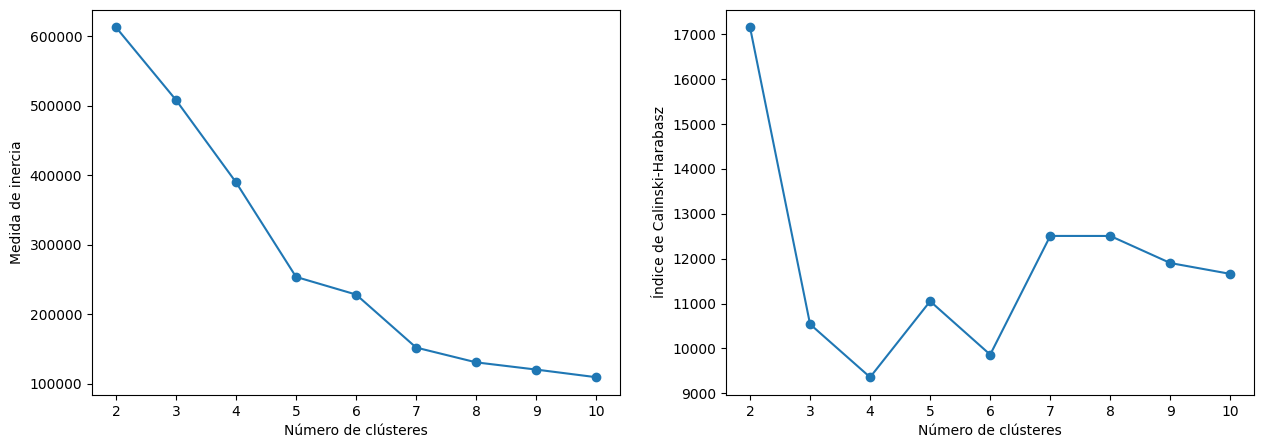

In [80]:
from sklearn.cluster import KMeans

rincercia = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de incercia")

Redacte una conclusión comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz. Determine el número óptimo de clusters (k) e interprete cómo cada métrica justifica dicha selección.

Interpretación del método del codo

Al analizar los valores de inercia, se observa que esta disminuye conforme aumenta el número de clústeres, lo cual es normal en K-means. Sin embargo, no todas las reducciones son igual de relevantes.

Las mayores caídas de inercia ocurren entre K = 2 y K = 4, lo que indica que agregar clústeres en ese rango mejora significativamente el modelo. A partir de K = 5, la reducción de la inercia comienza a ser mucho menor, señal de que añadir más clústeres aporta beneficios cada vez más limitados.

Aunque hay una caída puntual en K = 6, la tendencia general muestra que la curva empieza a aplanarse después de K = 4 o K = 5, lo que sugiere que ahí se encuentra el “codo”.

Conclusión:
Buscando un equilibrio entre buen ajuste y simplicidad del modelo, K = 4 o K = 5 son opciones razonables. Para confirmar esta elección, es recomendable visualizar el gráfico del codo y complementar el análisis con otras métricas de evaluación.

Interpretación del índice de Calinski-Harabasz

El índice de Calinski-Harabasz evalúa qué tan bien están formados los clústeres, considerando tanto su cohesión interna como su separación entre grupos. Cuanto más alto es el valor, mejor es la calidad del agrupamiento.

Al analizar los valores obtenidos, se observa que el índice aumenta de forma constante a medida que crece el número de clústeres, desde K = 2 hasta K = 10. El valor más alto se alcanza en K = 10, lo que indica que, dentro del rango evaluado, este número de clústeres ofrece la mejor separación y densidad según esta métrica.

En conclusión, desde la perspectiva del índice de Calinski-Harabasz, el valor óptimo de k sería K = 10, ya que maximiza la calidad del agrupamiento en términos de estructura y diferenciación entre clústeres.

Comparación de métricas y elección de k óptimo

Para determinar el número óptimo de clústeres, se compararon dos métricas: inercia (método del codo) y índice de Calinski-Harabasz.

El método del codo muestra que la inercia disminuye fuertemente hasta K = 4 o K = 5. A partir de ese punto, la mejora es cada vez menor, lo que indica que agregar más clústeres no aporta beneficios significativos en la cohesión interna. Esto sugiere que el modelo ya captura bien la estructura principal de los datos con pocos clústeres.

Por otro lado, el índice de Calinski-Harabasz aumenta de forma continua hasta K = 10, lo que indica una mejora progresiva en la separación entre clústeres. Sin embargo, esta métrica tiende a favorecer valores altos de k, incluso cuando los clústeres empiezan a volverse muy pequeños y difíciles de interpretar.

Al comparar ambas métricas, se observa una diferencia clara:

La inercia prioriza simplicidad y cohesión.

Calinski-Harabasz prioriza separación, aun a costa de mayor complejidad.

Considerando la interpretabilidad del modelo y evitando un sobre-agrupamiento innecesario, se elige K = 4 como el valor óptimo. Este número ofrece un buen equilibrio entre calidad del agrupamiento y simplicidad, capturando la estructura esencial de los datos sin introducir clústeres excesivamente granulares.

# 🎯 **EJ 3: USA EL SIGUIENTE DATASET CON KMEANS++**
Cargue el dataset dataset_cuatro_separables_peque y realice el siguiente análisis de agrupamiento (clustering):

Determinación del k óptimo: Utilice el algoritmo k-means para calcular y graficar el método del codo con un rango de k razonable (por ejemplo, de 2 a 15 clusters).

Selección: Con base en los gráficos, justifique y seleccione el número óptimo de clusters (k_optimo).

Modelo final: Ajuste un modelo final de k-means utilizando el k_optimo.

Visualización: Visualice los resultados del agrupamiento y que los puntos estén coloreados según el cluster asignado. Incluya los centroides en la visualización.

✅ Dataset cargado desde URL GitHub


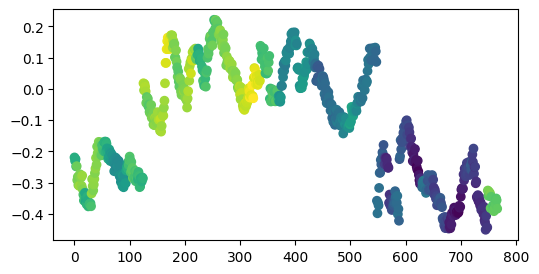

In [82]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_separables_peque.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🚀 ¡TALLER FINALIZADO!"

In [87]:
rincercia_new = np.zeros(14) # For k from 2 to 15 (15-2+1 = 14 values)
for k in np.arange(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robust results
    kmeans.fit(Dx)
    rincercia_new[k-2] = kmeans.inertia_

print("Inertia values for k from 2 to 15:", rincercia_new)


Inertia values for k from 2 to 15: [9400566.8311098  4179085.02015092 2350554.67650694 1504662.06403265
 1045348.9367652   768023.46847466  588497.67326571  465001.48123277
  376882.70721389  311189.82019341  262720.92358295  223377.01052643
  192391.88999196  167643.59647779]


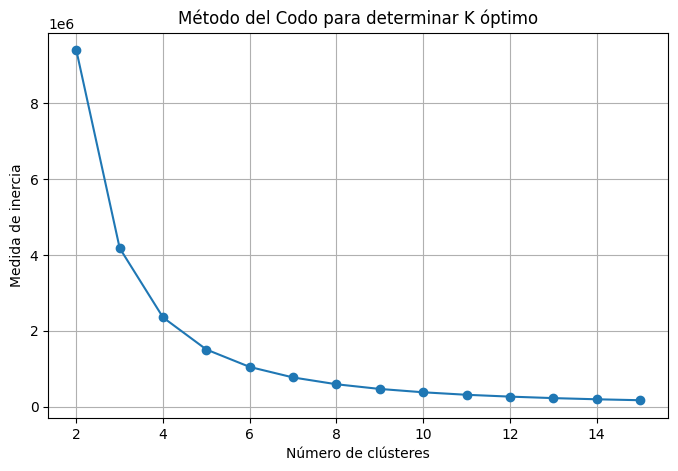

In [88]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(2, 16), rincercia_new, linestyle='-', marker='o')
ax.set_xlabel('Número de clústeres')
ax.set_ylabel('Medida de inercia')
ax.set_title('Método del Codo para determinar K óptimo')
plt.grid(True)
plt.show()

### Conclusión sobre el K Óptimo (Método del Codo)

Al analizar el gráfico del método del codo, podemos observar la inercia (suma de las distancias cuadradas de cada punto a su centroide más cercano) en función del número de clústeres (K). La inercia tiende a disminuir a medida que aumenta K, ya que con más clústeres, los puntos están más cerca de sus respectivos centroides.

El objetivo del método del codo es encontrar el punto en el que la tasa de disminución de la inercia cambia drásticamente, formando un 'codo' en el gráfico. Este punto sugiere el número óptimo de clústeres, ya que añadir más clústeres después de este punto no proporciona una mejora sustancial en la cohesión dentro de los clústeres, sino que simplemente los divide en grupos más pequeños y menos significativos.

Observando el gráfico generado, se puede identificar un 'codo' prominente en **K = 4**. La disminución de la inercia es significativa hasta K=4, y luego la curva se aplana, lo que indica que la ganancia marginal de añadir clústeres adicionales más allá de K=4 es menor. Por lo tanto, el **K óptimo es 4** para este dataset, ya que ofrece un buen equilibrio entre la reducción de la inercia (buena cohesión interna de los clústeres) y la simplicidad del modelo.

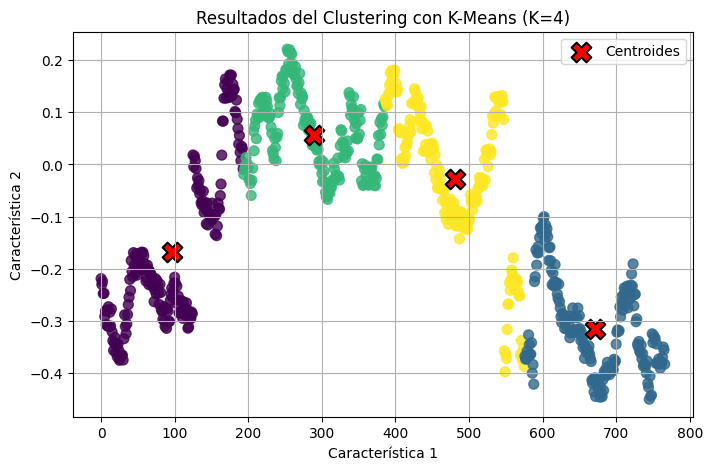

In [89]:
k_optimo = 4
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
kmeans_final.fit(Dx)

Dyp_final = kmeans_final.labels_
cDx_final = kmeans_final.cluster_centers_

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp_final, cmap='viridis', s=50, alpha=0.8)
ax.scatter(cDx_final[:,0], cDx_final[:,1], marker='X', s=200, c='red', edgecolor='black', linewidth=1.5, label='Centroides')
ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_title(f'Resultados del Clustering con K-Means (K={k_optimo})')
ax.legend()
plt.grid(True)
plt.show()